# Generate residual maps with real galaxies

This notebooks show a working example for generating residual maps, as they would be obtained from a rough model of a strongly lensed galaxy.

We use real observations of galaxies from the COSMOS survey, along with parametric fit (as Sérsic profiles) to simulate an inaccurate model $-$ i.e. too simple $-$ of a complex galaxy. By using the real galaxy to generate a noisy observations, and the parametric to generate corresponding model, we are able to generate a residual map that mimics the result of a proper model optimization.

## Import modules

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rc('image', interpolation='none')

import os
import copy
import numpy as np
import pandas as pd
from pprint import pprint
from astropy.io import fits
from matplotlib.colors import LogNorm
from lenstronomy.Util import param_util
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.light_model import LightModel

# seed for noise
np.random.seed(18)

cmap_residuals = plt.get_cmap('BuPu_r') #plt.get_cmap('RdBu_r')
cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)

## Load the dataset

Here we load all the sample of galaxy images, as well as related Sersic parameters (and other metadata). Those galaxies have been obtained through careful filtering and resizing of the images, to have a final size of 64$\times64$ pixels.

In [2]:
def normalize_image(images):
    """function to normalize the cutouts"""
    for i in range(len(images)):
        img_max = images[i].max()
        images[i]=images[i]/img_max
    return images

#Read the images and the features from the google drive
galaxy_images = np.load('../data/source_img/Images_Filtered_Rotated.npy')
df = pd.read_csv('../data/source_img/Labels_Filtered.csv', index_col=0)
print(df.columns)

#Bring images to a proper tensorial form
galaxy_images = normalize_image(galaxy_images)
galaxy_images = np.array(galaxy_images)
print(galaxy_images.shape)

Index(['COSMOS_index', 'COSMOS_Bulge_HLR', 'COSMOS_Bulge_I', 'COSMOS_Bulge_n',
       'COSMOS_Bulge_phi', 'COSMOS_Bulge_q', 'COSMOS_Bulge_x0',
       'COSMOS_Bulge_y0', 'COSMOS_Disk_HLR', 'COSMOS_Disk_I', 'COSMOS_Disk_n',
       'COSMOS_Disk_phi', 'COSMOS_Disk_q', 'COSMOS_Disk_x0', 'COSMOS_Disk_y0',
       'COSMOS_Sersic_HLR', 'COSMOS_Sersic_I', 'COSMOS_Sersic_n',
       'COSMOS_Sersic_phi', 'COSMOS_Sersic_q', 'COSMOS_Sersic_x0',
       'COSMOS_Sersic_y0', 'COSMOS_noise', 'COSMOS_use_bulgefit', 'IDENT',
       'Noise_mean', 'Noise_std', 'Original_R_cut', 'Original_x_size',
       'Original_y_size', 'Sersic_HLR', 'Sersic_HLR_err', 'Sersic_I',
       'Sersic_I_err', 'Sersic_n', 'Sersic_n_err', 'Sersic_phi',
       'Sersic_phi_err', 'Sersic_q', 'Sersic_q_err', 'Sersic_r_chi_sq',
       'Sersic_x0', 'Sersic_x0_err', 'Sersic_y0', 'Sersic_y0_err', 'mag_auto',
       'max_I', 'min_I', 'zphot', 'SNR', 'SNR_COSMOS', 'COSMOS_R_cut',
       'NonUniformity', 'R_cut', 'PSNR', 'log_NU'],
      dtype

In [3]:
print("number of samples", len(galaxy_images))

number of samples 19247


## Setup lenstronomy light profiles

We first define some constant values for the notebook.
The source magnitude and scale could be varied to generate more residual maps.

In [4]:
numPix = 64  # number of pixels per side
source_magnitude = 23  # will scale the total flux of the source
source_scale = 0.5  # will scale the size of the source

We define a function that uses lenstronomy to generate simulated lensed arcs, either from a real sources, or from the corresponding Sérsic profile. It is possible to add realistic noise (e.g. to simulate observed data), and shift the center of the source with respect to the center of the final image.

In [5]:
def simulate_image(dataset_index, source_type='real', add_noise=True, center_x=0, center_y=0):
    """
    Function that generate a convolved image of lensed arcs, with or without realistic noise
    based on a real image of a galaxy or from its parametric fit.
    Centering of the source can be set by center_x, center_y.
    """
    deltaPix_cosmos = 0.08
    if source_type == 'real':
        source_light_model_list = ['INTERPOL']
        source_image = np.squeeze(galaxy_images[dataset_index])
        import skimage.restoration
        source_image = skimage.restoration.denoise_wavelet(source_image)
        kwargs_source = [{
            'magnitude': source_magnitude,
            #'amp': 50,
            'image': source_image,
            'phi_G': df['Sersic_phi'][dataset_index],  # undo rotation that was applied on real galaxy images
            'scale': deltaPix_cosmos * source_scale,
            'center_x': center_x,
            'center_y': center_y,
        }]
    else:
        source_light_model_list = ['SERSIC_ELLIPSE']
        # convert to e1, e2
        e1, e2 = param_util.phi_q2_ellipticity(df['Sersic_phi'][dataset_index], 
                                               df['Sersic_q'][dataset_index])
        # correct center obtain from the different coordinates origin and units
        center_x0 = (df['Sersic_x0'][dataset_index] - numPix/2.) * deltaPix_cosmos
        center_y0 = (df['Sersic_y0'][dataset_index] - numPix/2.) * deltaPix_cosmos
        #print(center_x0, center_y0)
        kwargs_source = [{
            'magnitude': source_magnitude,
            #'amp': 12,
            'R_sersic': df['Sersic_HLR'][dataset_index] * deltaPix_cosmos * source_scale,
            'n_sersic': df['Sersic_n'][dataset_index],
            'e1': e1,
            'e2': e2,
            'center_x': center_x0 + center_x,
            'center_y': center_y0 + center_y,
        }]
    
    # setup the HST PSF and other instrument settings
    psf_kernel = fits.open('../data/psf.fits')[0].data
    kwargs_single_band_hst = HST().kwargs_single_band()
    kwargs_single_band_hst['kernel_point_source'] = psf_kernel / psf_kernel.sum()
    
    # setup models
    kwargs_model = {
        'lens_model_list': ['PEMD'],
        'source_light_model_list': source_light_model_list,
    }
    # parameters of the mass model
    kwargs_lens = [{
        'theta_E': 1,
        'gamma': 2,
        'e1': 0.1, 
        'e2': 0.1,
        'center_x': 0,
        'center_y': 0,
    }]
    sim_api = SimAPI(numpix=numPix, 
                     kwargs_single_band=kwargs_single_band_hst, 
                     kwargs_model=kwargs_model)
    # if needed, convert the choice of magnitude into an amplitude 'amp' parameter for lenstronomy 
    if 'magnitude' in kwargs_source[0]:
        _, kwargs_source, _ = sim_api.magnitude2amplitude(kwargs_source_mag=kwargs_source)
        
    # simulate the image
    image_model = sim_api.image_model_class(kwargs_numerics=None)
    image = image_model.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_source)
    # add realistic noise from instrumental settings
    if add_noise:
        image += sim_api.noise_for_model(model=image)
    # get an image of the (unlensed) source
    source = image_model.source_surface_brightness(kwargs_source, de_lensed=True, unconvolved=True)
    # retrieve the true noise map
    noise_map = np.sqrt(image_model.Data.C_D)
    return image, source, noise_map

We define a function that generate then display a single image, based on the index of the galaxy in the catalog.

chosen index 12214


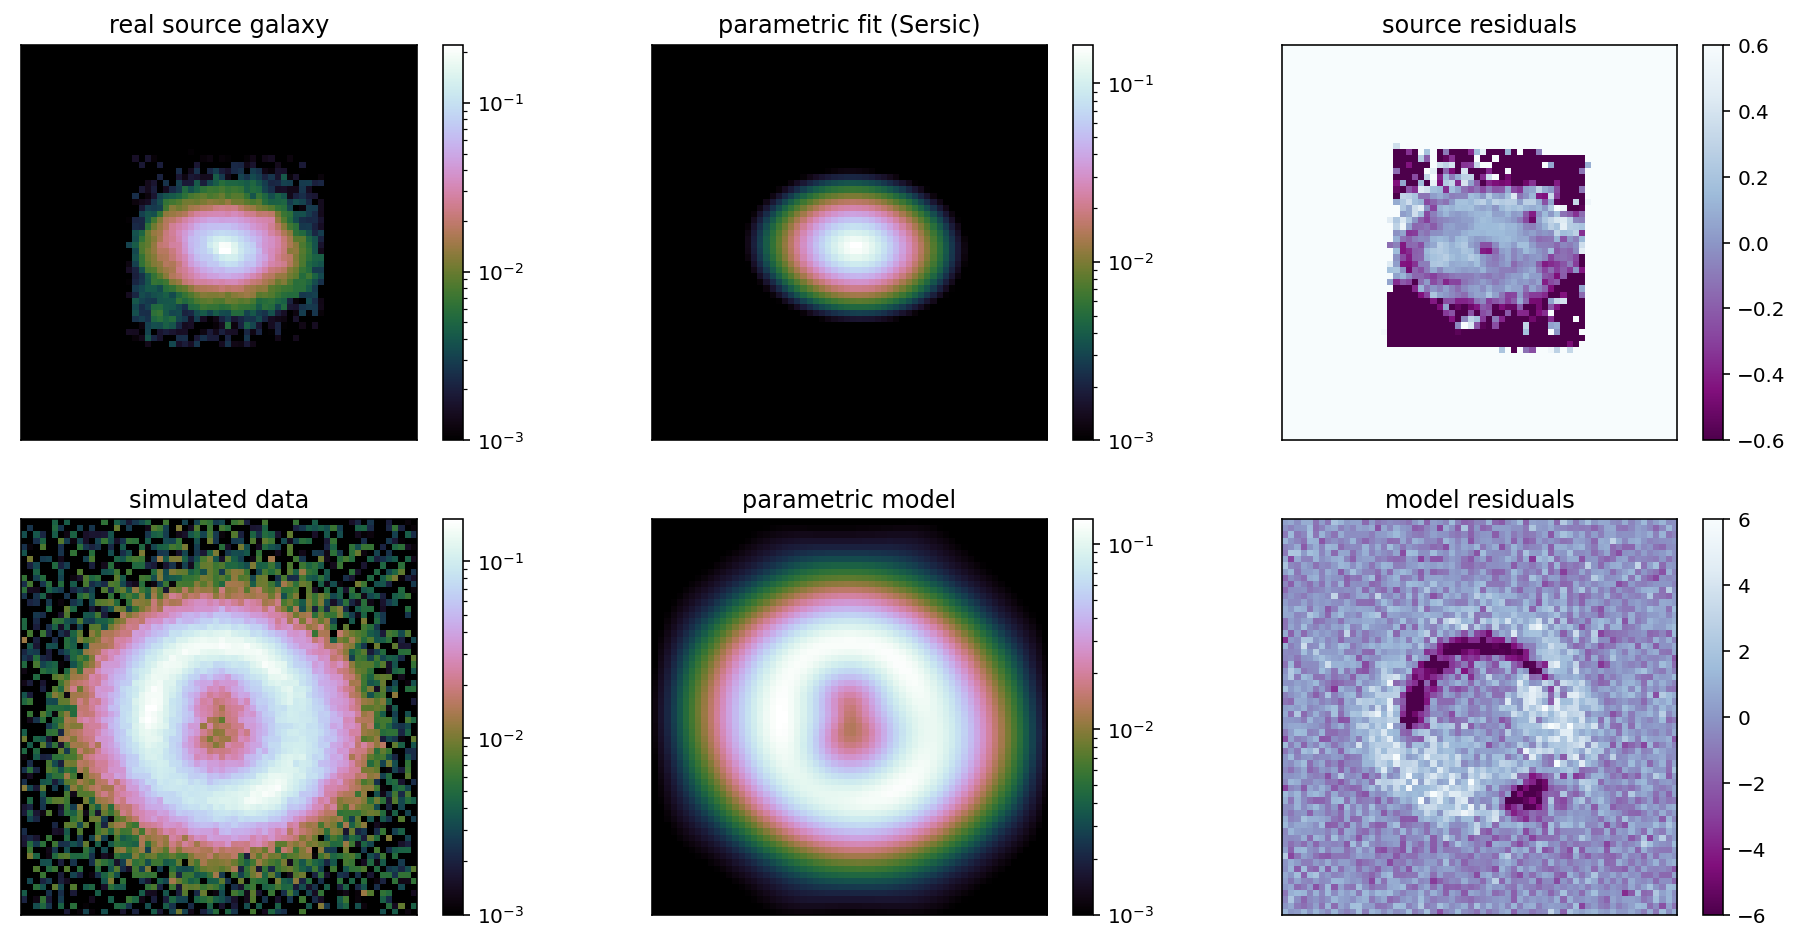

In [15]:
def plot_example(dataset_index, center_x=0, center_y=0):
    data_real, source_real, noise_map = simulate_image(dataset_index, source_type='real',
                                                       center_x=center_x, center_y=center_y)
    model_param, source_param, _ = simulate_image(dataset_index, source_type='param', add_noise=False,
                                                  center_x=center_x, center_y=center_y)
    model_residuals = (model_param - data_real) / noise_map
    source_residuals = (source_param - source_real) / np.abs(source_param)

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    ax = axes[0, 0]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("real source galaxy")
    im = ax.imshow(source_real, origin='lower', norm=LogNorm(1e-3), cmap=cmap_flux)
    fig.colorbar(im, ax=ax)
    ax = axes[1, 0]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("simulated data")
    im = ax.imshow(data_real, origin='lower', norm=LogNorm(1e-3), cmap=cmap_flux)
    fig.colorbar(im, ax=ax)
    ax = axes[0, 1]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("parametric fit (Sersic)")
    im = ax.imshow(source_param, origin='lower', norm=LogNorm(1e-3), cmap=cmap_flux)
    fig.colorbar(im, ax=ax)
    ax = axes[1, 1]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("parametric model")
    im = ax.imshow(model_param, origin='lower', norm=LogNorm(1e-3), cmap=cmap_flux)
    fig.colorbar(im, ax=ax)
    ax = axes[0, 2]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("source residuals")
    im = ax.imshow(source_residuals , origin='lower', cmap=cmap_residuals, vmin=-0.6, vmax=0.6)
    fig.colorbar(im, ax=ax)
    ax = axes[1, 2]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("model residuals")
    im = ax.imshow(model_residuals, origin='lower', cmap=cmap_residuals, vmin=-6, vmax=6)
    fig.colorbar(im, ax=ax)
    plt.savefig('../figures/interpol/interpol_sersic.png')
    
    plt.show()

# choose randomly the index or not
#index = np.random.choice(np.arange(len(galaxy_images)), 1)[0]
index = 12214
print("chosen index", index)
plot_example(index, center_x=0.1, center_y=-0.1)

## Generate several samples of residual maps

Here we plot a grid of several samples to have an overview of the residual maps. We also display the reduced chi2 $\chi^2_\nu$ value corresponding to each map.

Note: we can imagine to have some criterion on $\chi^2_\nu$ to accept or not a given map, because we see that a lot of maps contain really strong residuals.

In [10]:
def generate_residual_map(dataset_index):
    data, _, noise_map = simulate_image(dataset_index, source_type='real')
    model, _, _ = simulate_image(dataset_index, source_type='param', add_noise=False)
    model_residuals = (model - data) / noise_map
    return model_residuals

def plot_samples_grid(num_samples, randomize=False):
    fig, axes = plt.subplots(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), figsize=(10, 10))
    axes = axes.flatten()
    indices = np.arange(len(axes))
    if randomize is True:
        indices = np.random.choice(indices, len(axes), replace=False)
    for i in range(len(axes)):
        res_map = generate_residual_map(indices[i])
        red_chi2 = np.sum(res_map**2)/(res_map.shape[0]*res_map.shape[1])

        ax = axes[i]
        im = ax.imshow(res_map, origin='lower', cmap=cmap_residuals, vmin=-6, vmax=6)
        ax.text(3, 3, r"$\chi^2_\nu={:.1f}$".format(red_chi2), fontsize=8, color='black')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig('../figures/interpol/sample_model_residual.png')
    plt.show()

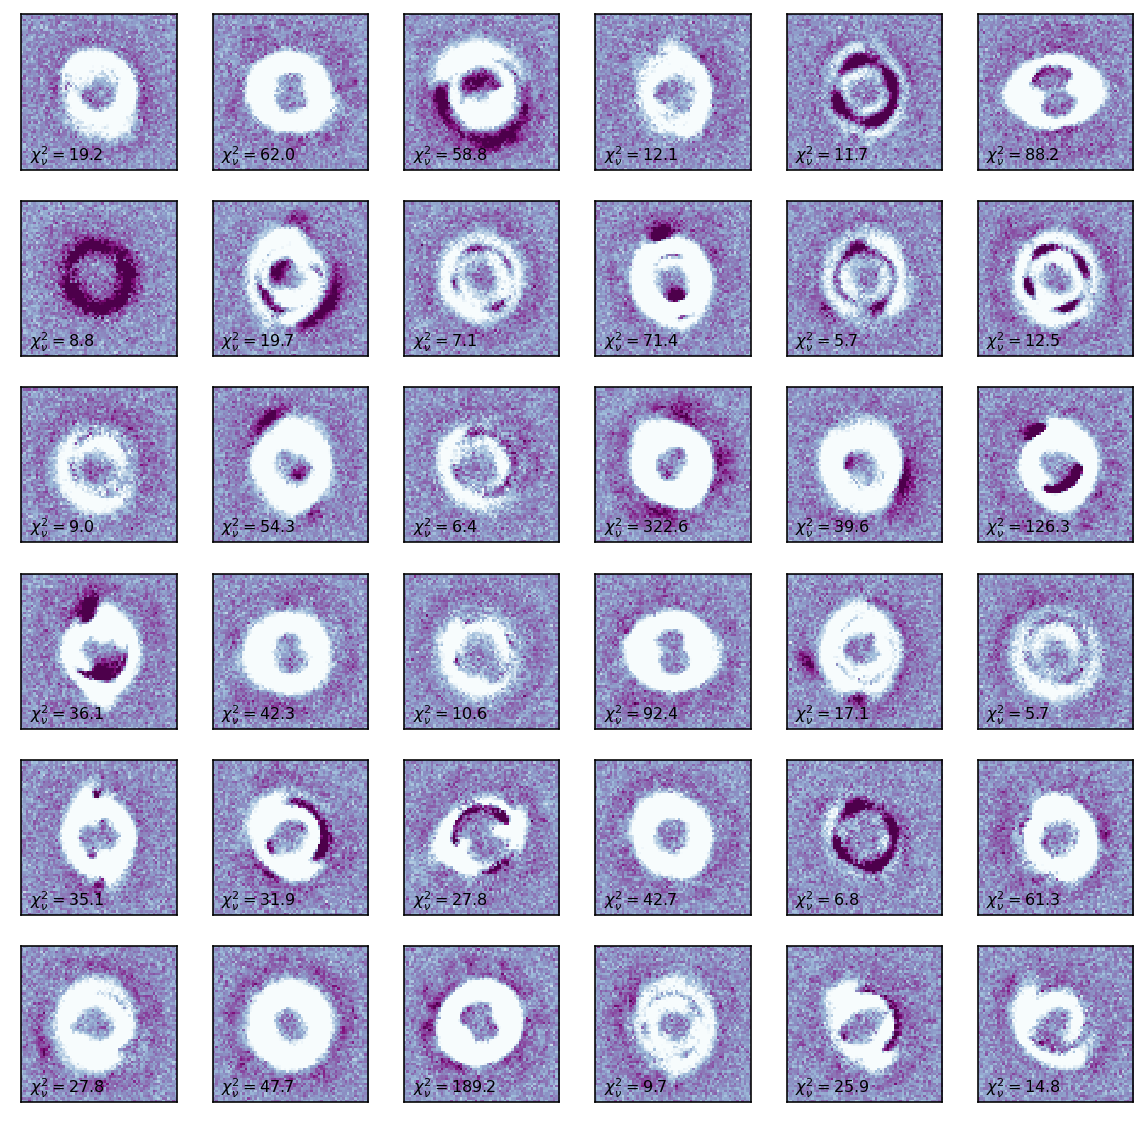

In [11]:
plot_samples_grid(36, randomize=True)